# Imports

In [571]:
# Import necessary libraries for mathematical operations and plotting
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors

# Import astropy modules for working with astronomical data
import astropy.units as u
from astropy.visualization import simple_norm, SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy.coordinates import angular_separation, Angle, SkyCoord
from astropy.stats import sigma_clipped_stats
from astropy.io import fits
from astropy.nddata import Cutout2D
# Import os for directory operations
import os
# Import astroalign for aligning astronomical images
import astroalign as align
# Import twirl for peak finding and WCS (World Coordinate System) computations
from twirl import find_peaks
from twirl import gaia_radecs
from twirl.geometry import sparsify
from twirl import compute_wcs
# Import photutils for aperture photometry
from photutils.aperture import SkyCircularAperture
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture
from pylab import figure, cm
# Import pandas for data manipulation
import pandas as pd

import random

In [572]:
#Constnats
# BLUE_FILTER_COLOR =  'Blues'
# RED_FILTER_COLOR =  'Reds'

BLUE_FILTER_COLOR =  cm.grey
RED_FILTER_COLOR =  cm.grey

# Target

In [573]:
DIRECTORY="m2/"
# DIRECTORY="m13/"

# Gather all the files

In [574]:
# Define the directories where the FITS files are stored
directory_b_filter = DIRECTORY + "Light_B.fits"

# Load the FITS files into variables
b_filter_fits = fits.open(directory_b_filter)
b_filter_fits = b_filter_fits[0]

# Use twirl to find peaks

In [575]:
peak_location_b_filter = find_peaks(b_filter_fits.data)[0:20]

# Obtain and filter RA/DEC coordinates from the Gaia catalog

In [576]:
b_filter_center     = (b_filter_fits.header['RA'], b_filter_fits.header['DEC']) 
fov_b_filter        = 1.2 * 0.65
all_radecs_b_filter = gaia_radecs(b_filter_center, fov_b_filter)
thrushold           = 0.01 # degrees
all_radecs_b_filter = sparsify(all_radecs_b_filter, thrushold)


# Compute WCS coordinates

In [577]:
# we only keep the 12 brightest stars from gaia
wcs_b_filter = compute_wcs(peak_location_b_filter, all_radecs_b_filter[0:20], tolerance = 10)

# Update Header for the lights with the new WCS

In [578]:
b_filter_fits.header.update(wcs_b_filter.to_header())

# Normalize the lights

In [579]:
b_filter_fits.data = b_filter_fits.data/(16*120.0)

# Get the co-orditane of M2 stars and their brightness from Database (CANFAR's Stetson Database)

In [580]:
# load the data from memory
coords = pd.read_csv( DIRECTORY + "NGC7089.pos", sep='[ ]{2,}', engine='python') # replace anything w 2 or more spaces with just a space
mags = pd.read_csv(DIRECTORY + "NGC7089.pho", sep='[ ]{1,}', engine='python') # replace anything w 1 or more spaces with just a space

# Let's extract what we need from the stetson database

In [581]:
# add coloum names to the coordinate file
coords.rename(columns={'323.36209232807' : 'RA', '-00.84555554920' : 'DEC'}, inplace=True) # replace the orgonal col names for somethig meaningfull

# Convert the DEC column to string type first
coords['DEC'] = coords['DEC'].astype(str)

# Now you can use the .str accessor to replace spaces
coords['DEC'] = coords['DEC'].str.replace(" ", "")

# Convert the DEC column back to float type
coords['DEC'] = coords['DEC'].astype(float)

# Perform the merge with the photometry data
stetson = pd.merge(coords[["Reference", 'RA', 'DEC']], mags[["Reference", 'B', 'sigma.1', 'R', 'sigma.3']], how='inner', on=['Reference'])

# Filter the stars with magnitude of 18 or brighter
stetson = stetson[(stetson.B < 23) & (stetson.R < 23)]


# Lets plot what we extracted

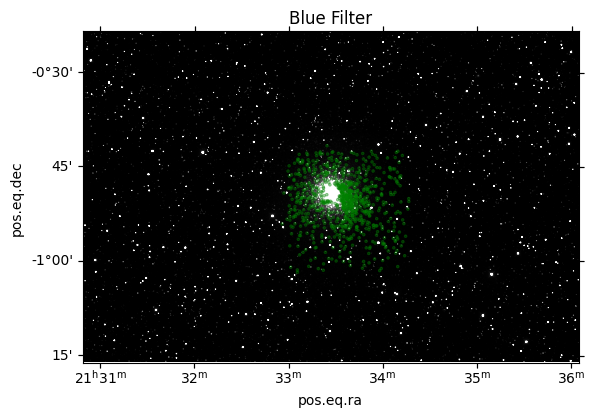

<Figure size 640x480 with 0 Axes>

In [582]:
stetson_pos_b_filter = np.array(wcs_b_filter.world_to_pixel_values( stetson[["RA", "DEC"]] ))
ax1 = plt.subplot(projection = wcs_b_filter)
ax1.imshow(b_filter_fits.data, vmin = np.median(b_filter_fits.data), vmax = 3 * np.median(b_filter_fits.data), cmap = BLUE_FILTER_COLOR)
_ = CircularAperture(stetson_pos_b_filter, 10).plot(color = "g", alpha = 0.5)
ax1.set_title('Blue Filter')

plt.show()
plt.savefig(DIRECTORY + "Steton Catalog Stars.png")
plt.clf()

# Lets define & Work with a small subsection
#### FOV too large

In [583]:
position = (2200, 1000)
size = (1000, 1000)
cutout_b_filter = Cutout2D(b_filter_fits.data, position, size, wcs = wcs_b_filter)


In [584]:
b_filter_analysis = fits.PrimaryHDU()
b_filter_analysis.data = cutout_b_filter.data
b_filter_analysis.header.update(cutout_b_filter.wcs.to_header())


# Use TWIRL to compute WCS for the cutout

In [585]:
#compute wcs for this cutout
peaks_b_filter = find_peaks(b_filter_analysis.data)[0:20]
wcs_cutout_b_filter = compute_wcs(peaks_b_filter, all_radecs_b_filter[0:20], tolerance = 10)
stetson_pos_b_filter = np.array(wcs_cutout_b_filter.world_to_pixel_values(stetson[["RA", "DEC"]]))


# Find peaks using DAO Star Finder

In [586]:
mean, median, std = sigma_clipped_stats(b_filter_analysis.data, sigma = 3.0)

daofind = DAOStarFinder(fwhm = 5.0, threshold = 2 *std)
sources = daofind(b_filter_analysis.data - median)
for col in sources.colnames:  
    if col not in ('id', 'npix'):
        sources[col].info.format = '%.2f'  # for consistent table output

# Lets convert the DAOStarFinder results into a pandas table & get what we need

In [587]:
detected_stars      = sources.to_pandas()
detected_stars      = detected_stars[(detected_stars.flux > .60)] # Get rid of anything fainter than 0.79 mag
detected_locaions   = np.transpose((detected_stars['xcentroid'], detected_stars['ycentroid'])) # pandas object backt o numpy array


#  Overlay the Stetson star locations & DAO Star Finder peak locations on the cutout

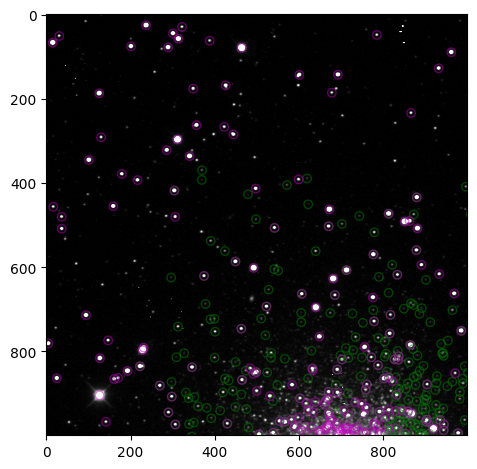

<Figure size 640x480 with 0 Axes>

In [588]:

plt.imshow(b_filter_analysis.data, vmin = np.median(b_filter_fits.data), vmax = 3 * np.median(b_filter_fits.data), cmap= "Greys_r")
_ = CircularAperture(stetson_pos_b_filter, 10).plot(color="g", alpha=0.5)
_ = CircularAperture(detected_locaions, 10).plot(color="m", alpha=0.5)
ax1.set_title('Peaks found using TWIRL in B filter cutout')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()
plt.savefig(DIRECTORY + "Stetson(g) and Detected(m) stars.png")
plt.clf()

# Add the detected coordinates from TWIRL into the to the DAOStarFinder results

In [589]:
#get RA and DEC in degrees (SkyCoord Object) in the detected steson stars
detected_stars['coords'] = wcs_cutout_b_filter.pixel_to_world(detected_stars['xcentroid'], detected_stars['ycentroid'])
coordinates_stetson = SkyCoord(stetson.RA, stetson.DEC, unit=u.degree) 

#get RA and DEC in degrees (SkyCoord Object) in the DAOStarFinder peaks
det_radec = wcs_cutout_b_filter.pixel_to_world(detected_stars['xcentroid'], detected_stars['ycentroid'])
coordinates_detected = SkyCoord(det_radec.ra, det_radec.dec)

# Match with stars that are present in both tables based on SkyCoordinate Object

In [590]:
idx, d2d, d3d = coordinates_detected.match_to_catalog_sky(coordinates_stetson)
stetson['sky'] = SkyCoord(stetson.RA, stetson.DEC, unit=u.degree)

max_sep = 1.0 * u.arcsec
sep_constraint = d2d < max_sep
coordinates_matched = coordinates_detected[sep_constraint]
catalog_matches = coordinates_stetson[idx[sep_constraint]]
detected_stars['coords'] = coordinates_detected



# Define a function to convert B-R magnitude values to effective Tempurature

In [591]:

# Define the empirical relation to convert B-R to temperature (in Kelvin)
def b_r_to_temp(b_r):
    log_temp = 3.939 - 0.395 * b_r + 0.208 * (b_r ** 2) - 0.064 * (b_r ** 3)
    temp = 10 ** log_temp
    return temp

# Make the CMD & HR

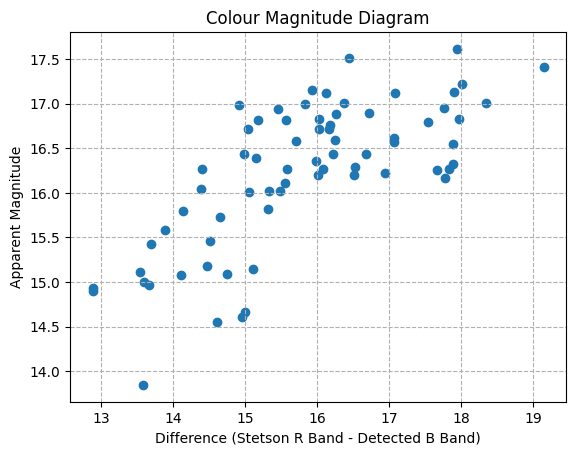

<Figure size 640x480 with 0 Axes>

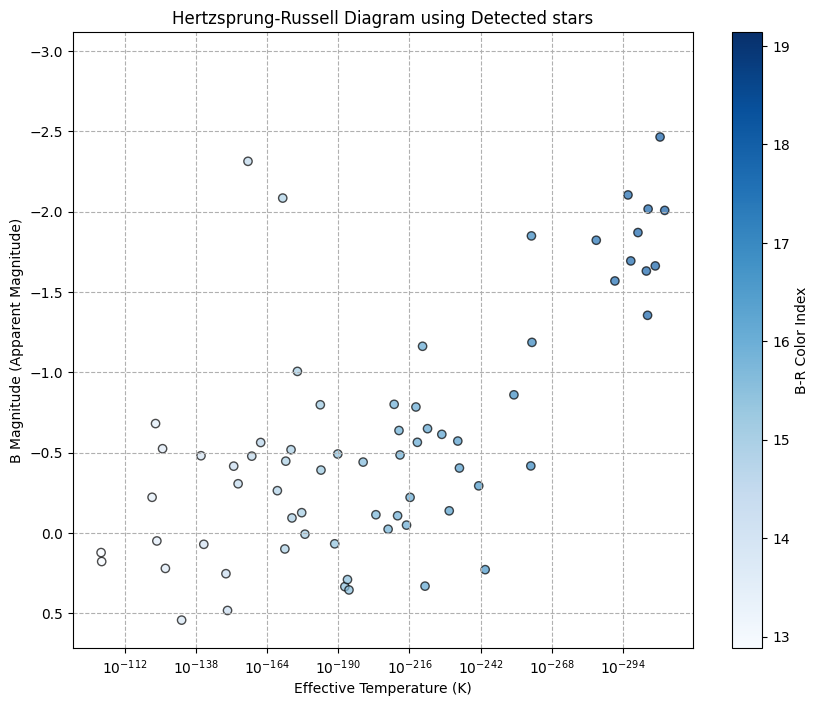

<Figure size 640x480 with 0 Axes>

In [592]:
# Get X axis
detected_and_matched_stars_mag = []
for i in detected_stars.index:
    for j in range(0,len(coordinates_matched)):
        if detected_stars.coords[i] == coordinates_matched[j]:
            detected_and_matched_stars_mag.append(detected_stars.mag[i])

stetson_and_matched_stars_r_band = []
for i in stetson.index:
    for j in range(0,len(catalog_matches)):
        if(stetson.sky[i] == catalog_matches[j]):
            stetson_and_matched_stars_r_band.append(stetson.R[i])

# get Y axix
apparent_mag = []
for i in stetson.index:
    for j in range(0,len(catalog_matches)):
        if(stetson.sky[i] == catalog_matches[j]):
            apparent_mag.append(stetson.B[i])


stetson_and_matched_stars_r_band = np.array(stetson_and_matched_stars_r_band)
detected_and_matched_stars_mag = np.array(detected_and_matched_stars_mag)
apparent_mag = np.array(apparent_mag)

fudge_factor = 0 * np.std(detected_and_matched_stars_mag)
difference = stetson_and_matched_stars_r_band - (detected_and_matched_stars_mag + fudge_factor)

plt.scatter(difference, apparent_mag)
plt.xlabel('Difference (Stetson R Band - Detected B Band)')
plt.ylabel('Apparent Magnitude')
plt.title('Colour Magnitude Diagram')
plt.grid(True, which="both", ls="--")  # Grid for both major and minor ticks
plt.savefig(DIRECTORY + "CMD.png")
plt.show()
plt.clf()



################ HR Diagram #############################################
# Calculate effective temperatures
efective_temp = b_r_to_temp(difference)

# Normalize the B-R values for intensity mapping
norm = mcolors.Normalize(vmin = min(difference), vmax = max(difference))
cmap = plt.get_cmap('Blues')

# Create the HR diagram with color intensity based on B-R values
plt.figure(figsize=(10, 8))
colors = cmap(norm(difference))
sc = plt.scatter(efective_temp, detected_and_matched_stars_mag, color = colors, edgecolors = 'k', alpha = 0.7)
plt.xscale('log')  # Use logarithmic scale for the x-axis
plt.gca().invert_xaxis()  # Invert x-axis for HR diagram
plt.gca().invert_yaxis()  # Invert y-axis to have brighter stars at the top
plt.xlabel('Effective Temperature (K)')
plt.ylabel('B Magnitude (Apparent Magnitude)')
plt.title('Hertzsprung-Russell Diagram using Detected stars')
plt.grid(True, which="both", ls="--")  # Grid for both major and minor ticks

# Add color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='B-R Color Index', ax=plt.gca())

plt.savefig(DIRECTORY + "HR Diagram.png")
plt.show()
plt.clf()

# Try using only the stetson calalog for Mag values to make cmd and HR

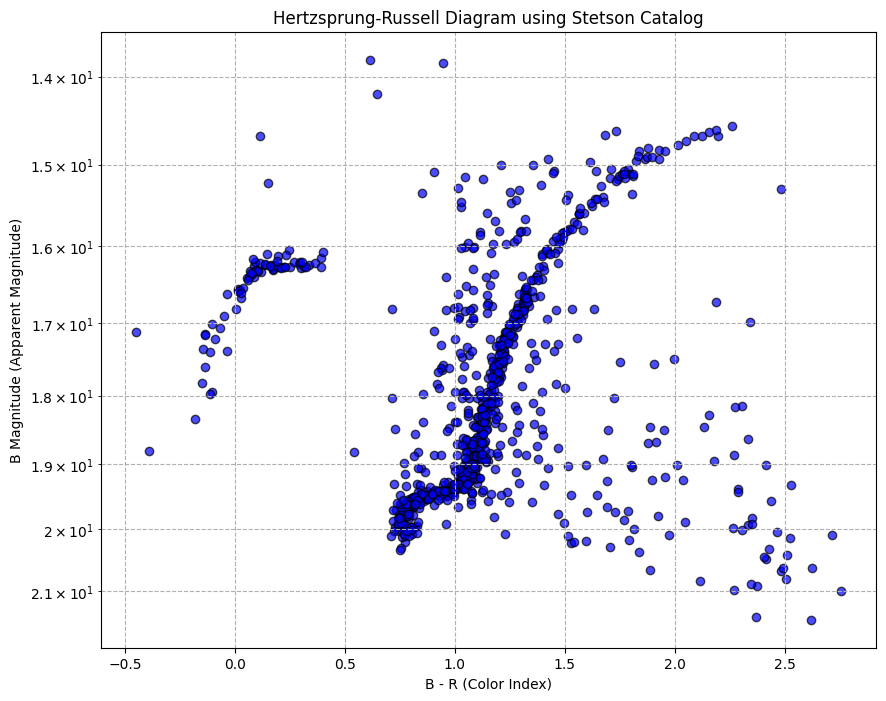

<Figure size 640x480 with 0 Axes>

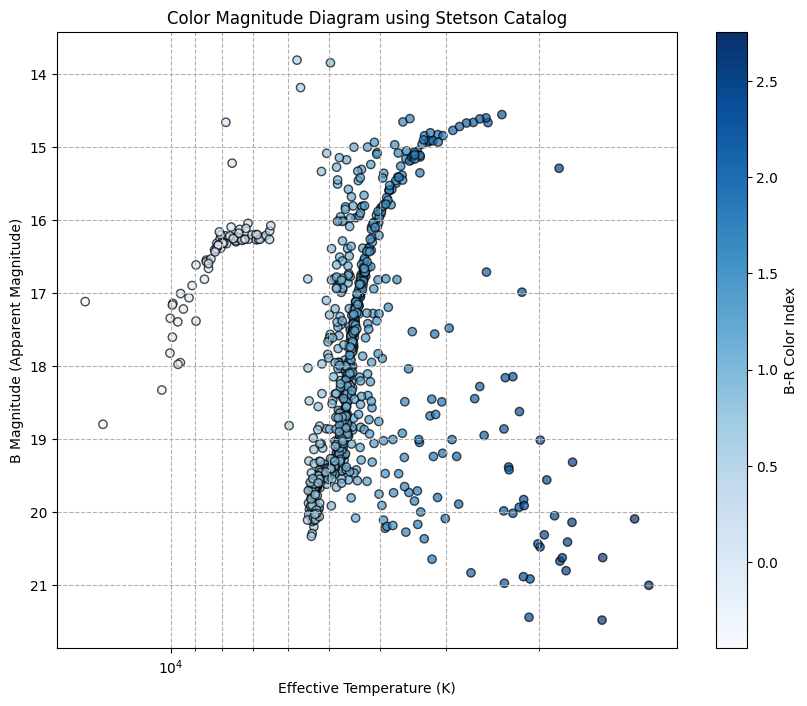

<Figure size 640x480 with 0 Axes>

In [593]:
# Create the HR diagram
plt.figure(figsize=(10, 8))
plt.scatter(stetson['B'] - stetson['R'], stetson['B'], color='blue', edgecolors='k', alpha=0.7)
plt.yscale('log')  # Use logarithmic scale for the y-axis
plt.gca().invert_yaxis()  # Invert y-axis for HR diagram
plt.xlabel('B - R (Color Index)')
plt.ylabel('B Magnitude (Apparent Magnitude)')
plt.title('Hertzsprung-Russell Diagram using Stetson Catalog')
plt.grid(True, which="both", ls="--")  # Grid for both major and minor ticks
plt.savefig(DIRECTORY + "CMD (Stetsons Data).png")
plt.show()
plt.clf()


# Calculate effective temperatures
stetson['Temperature'] = b_r_to_temp(stetson['B'] - stetson['R'])

# Normalize the B-R values for intensity mapping
norm = mcolors.Normalize(vmin=min(stetson['B'] - stetson['R']), vmax=max(stetson['B'] - stetson['R']))
cmap = plt.get_cmap('Blues')

# Create the HR diagram with color intensity based on B-R values
plt.figure(figsize=(10, 8))
colors = cmap(norm(stetson['B'] - stetson['R']))
sc = plt.scatter(stetson['Temperature'], stetson['B'], color=colors, edgecolors='k', alpha=0.7)
plt.xscale('log')  # Use logarithmic scale for the x-axis
plt.gca().invert_xaxis()  # Invert x-axis for HR diagram
plt.gca().invert_yaxis()  # Invert y-axis to have brighter stars at the top
plt.xlabel('Effective Temperature (K)')
plt.ylabel('B Magnitude (Apparent Magnitude)')
plt.title('Color Magnitude Diagram using Stetson Catalog')
plt.grid(True, which="both", ls="--")  # Grid for both major and minor ticks

# Add color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='B-R Color Index', ax=plt.gca())

plt.savefig(DIRECTORY + "HR Diagram (Stetson Data).png")
plt.show()
plt.clf()

# Make the CMD & HR (INCLUDING FUDGE FACTOR)

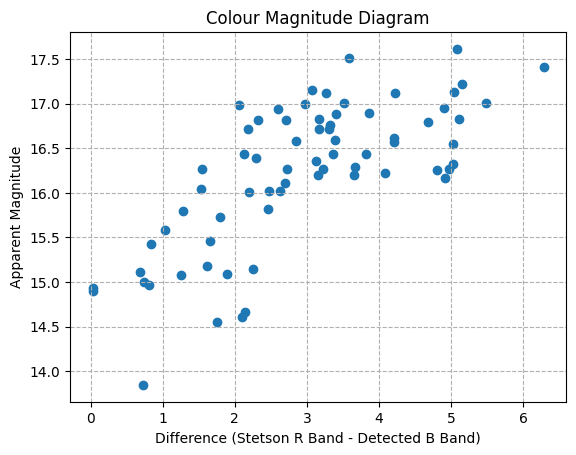

<Figure size 640x480 with 0 Axes>

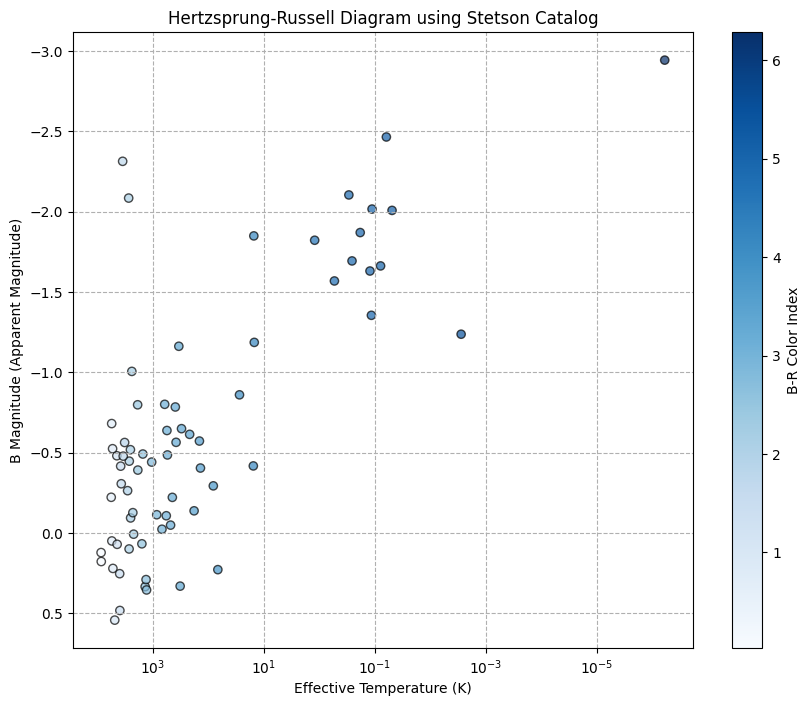

<Figure size 640x480 with 0 Axes>

In [594]:
# Get X axis
detected_and_matched_stars_mag = []
for i in detected_stars.index:
    for j in range(0,len(coordinates_matched)):
        if detected_stars.coords[i] == coordinates_matched[j]:
            detected_and_matched_stars_mag.append(detected_stars.mag[i])

stetson_and_matched_stars_r_band = []
for i in stetson.index:
    for j in range(0,len(catalog_matches)):
        if(stetson.sky[i] == catalog_matches[j]):
            stetson_and_matched_stars_r_band.append(stetson.R[i])

# get Y axix
apparent_mag = []
for i in stetson.index:
    for j in range(0,len(catalog_matches)):
        if(stetson.sky[i] == catalog_matches[j]):
            apparent_mag.append(stetson.B[i])


stetson_and_matched_stars_r_band = np.array(stetson_and_matched_stars_r_band)
detected_and_matched_stars_mag = np.array(detected_and_matched_stars_mag)
apparent_mag = np.array(apparent_mag)

fudge_factor = 16 * np.std(detected_and_matched_stars_mag)
difference = stetson_and_matched_stars_r_band - (detected_and_matched_stars_mag + fudge_factor)

plt.scatter(difference, apparent_mag)
plt.xlabel('Difference (Stetson R Band - Detected B Band)')
plt.ylabel('Apparent Magnitude')
plt.title('Colour Magnitude Diagram')
plt.grid(True, which="both", ls="--")  # Grid for both major and minor ticks
plt.savefig(DIRECTORY + "CMD w fudge factor.png")
plt.show()
plt.clf()



################ HR Diagram #############################################
# Calculate effective temperatures
efective_temp = b_r_to_temp(difference)

# Normalize the B-R values for intensity mapping
norm = mcolors.Normalize(vmin = min(difference), vmax = max(difference))
cmap = plt.get_cmap('Blues')

# Create the HR diagram with color intensity based on B-R values
plt.figure(figsize=(10, 8))
colors = cmap(norm(difference))
sc = plt.scatter(efective_temp, detected_and_matched_stars_mag, color = colors, edgecolors = 'k', alpha = 0.7)
plt.xscale('log')  # Use logarithmic scale for the x-axis
plt.gca().invert_xaxis()  # Invert x-axis for HR diagram
plt.gca().invert_yaxis()  # Invert y-axis to have brighter stars at the top
plt.xlabel('Effective Temperature (K)')
plt.ylabel('B Magnitude (Apparent Magnitude)')
plt.title('Hertzsprung-Russell Diagram using Stetson Catalog')
plt.grid(True, which="both", ls="--")  # Grid for both major and minor ticks

# Add color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='B-R Color Index', ax=plt.gca())

plt.savefig(DIRECTORY + "HR Diagram w fudge factor.png")
plt.show()
plt.clf()